In [49]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from ADMS_functions import plot_in_grid_box

In [190]:
folder = "/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/001/"
files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]

In [55]:
variable = "NO2"
choose_PG_class = "G"
coordinate_system = "gridded_latlon" # "gridded_latlon"

In [56]:
if coordinate_system == "raw_latlon":
    filepath = path.join(folder, "raw_processed_coordinates.nc")
elif coordinate_system == "gridded_latlon":
    filepath = path.join(folder, "gridded/", f"{variable}_PG_classes_grid.nc")

ds = xr.open_dataset(filepath)

In [137]:
PG_index = ["A", "B", "C", "D", "E", "F", "G"]
da = ds[variable][:, :, PG_index.index(choose_PG_class)]
array = np.rot90(da.values)

In [138]:
print("Before: ", np.sum(np.isnan(array)), "NaN values")
array[np.isnan(array)] = 0
print("After: ", np.sum(np.isnan(array)), "NaN values")

Before:  997 NaN values
After:  0 NaN values


In [139]:
array.shape

(84, 151)

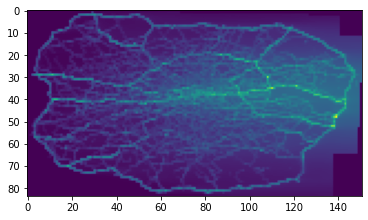

In [147]:
plt.imshow(array)

In [140]:
U, S, Vt = np.linalg.svd(array) # full_matrices=True

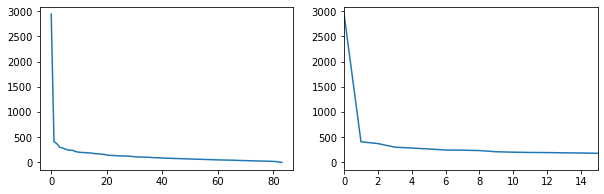

In [201]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
ax1.plot(S)
ax2.plot(S)
ax2.set_xlim((0, 15))
plt.show()

In [148]:
print(U.shape, S.shape, Vt.shape)

(84, 84) (84,) (151, 151)


In [149]:
np.diag(S).shape

(84, 84)

In [154]:
# Turn the S vector into a diagonal matrix
S_matrix = np.zeros((U.shape[1], Vt.shape[0]))
S_matrix[:np.diag(S).shape[0], :np.diag(S).shape[1]] = np.diag(S)
print(U.shape, S_matrix.shape, Vt.shape)

(84, 84) (84, 151) (151, 151)


In [153]:
# Does U . S_matrix . Vt = array ?
np.allclose(array, np.dot(U, np.dot(S_matrix, Vt)))

True

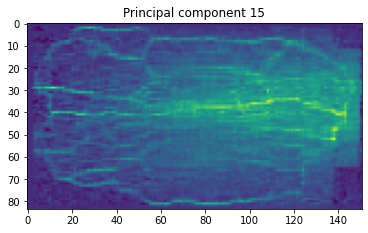

In [196]:
choose = 15
component = np.dot(U[:, :choose], np.dot(S_matrix[:choose, :choose], Vt[:choose, :]))
plt.imshow(component)
plt.title(f"Principal component {choose}")
plt.show()

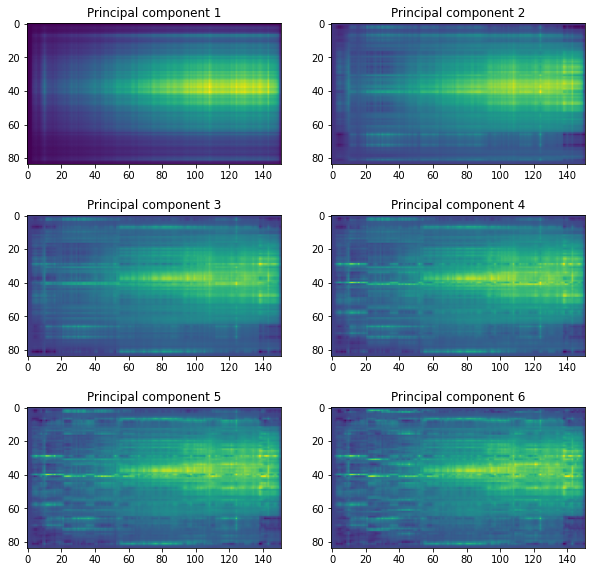

In [189]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axs = axs.ravel()

for i in range(len(axs)):
    component = np.dot(U[:, :i+1], np.dot(S_matrix[:i+1, :i+1], Vt[:i+1, :]))
    axs[i].imshow(component)
    axs[i].set_title(f"Principal component {i+1}")
plt.show()